# From Detection to Credibility: A Machine Learning Framework for Assessing News Source Reliability



**Motivation**

We want to apply our trained model to scraped news data from popular US media outlets and access the credibility of these media outlets. This way we can help the public to make more informed decisions about what media outlets they can trust. 


## Fake News Classification Dataset Information

The [Fake News Classification Dataset](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification) contains real and fake news articles. 

The dimensions are shown below:
- **Index:**: Index.
- **title:** Title of news article.
- **text:** Text content of news article.
- **label:** Whether news article is real (1) or fake (0).

The Fake News Dataset is split into 3 `csv` files (`part1.csv`, `part2.csv`, `part3.csv`) so that size does not exceed size limit to push changes to GitHub.

## Import Libraries

Please uncomment the code box below to pip install relevant dependencies for this notebook.

In [2]:
# !pip3 install -r requirements.txt

In [3]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# `langid` for an alternative language detection method
from langid import classify as langid_classify

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords
# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Part-of-speech tagging
from nltk import pos_tag
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk
# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

## Data Preparation (Loading CSV)

Load the 3 Fake News `csv` files into pandas DataFrames
- `part1.csv` is loaded into `data_raw1` DataFrame.
- `part2.csv` is loaded into `data_raw2` DataFrame.
- `part3.csv` is loaded into `data_raw3` DataFrame.

In [4]:
data_raw1 = pd.read_csv('part1.csv')
data_raw2 = pd.read_csv('part2.csv')
data_raw3 = pd.read_csv('part3.csv')

In [5]:
data_raw1.info()
print("Dataframe 1 Shape:", data_raw1.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24044 entries, 0 to 24043
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24044 non-null  int64 
 1   title       23894 non-null  object
 2   text        24033 non-null  object
 3   label       24044 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 751.5+ KB
Dataframe 1 Shape: (24044, 4)


In [6]:
data_raw2.info()
print("Dataframe 2 Shape:", data_raw2.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24044 entries, 0 to 24043
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24044 non-null  int64 
 1   title       23849 non-null  object
 2   text        24030 non-null  object
 3   label       24044 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 751.5+ KB
Dataframe 2 Shape: (24044, 4)


In [7]:
data_raw3.info()
print("Dataframe 3 Shape:", data_raw3.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24046 entries, 0 to 24045
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24046 non-null  int64 
 1   title       23833 non-null  object
 2   text        24032 non-null  object
 3   label       24046 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 751.6+ KB
Dataframe 3 Shape: (24046, 4)


In [8]:
data_raw1.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [9]:
data_raw2.head()

,Unnamed: 0,title,text,label
0,24044,Massachusetts governor would sign transgender ...,BOSTON (Reuters) - Massachusetts Governor Char...,0
1,24045,"Weakened Militarily, ISIS Still Has Power to S...","In the past few weeks, the Islamic State has s...",0
2,24046,SARAH JESSICA PARKER FEARS She’ll Be Attacked ...,"With absolutely NOTHING to back it up, Sarah J...",1
3,24047,Rosenstein may need to recuse himself from Rus...,WASHINGTON (Reuters) - U.S. Deputy Attorney Ge...,0
4,24048,Cop Arrested for Using Police Status to Rape L...,Home / Badge Abuse / Cop Arrested for Using Po...,1


In [10]:
data_raw3.head()

,Unnamed: 0,title,text,label
0,48088,Blue State Blues: The White House Loves the Ru...,The Trump White House seems quietly to be enjo...,0
1,48089,"Harassment Crisis Builds at Fox News, Despite ...",When the anchor Gretchen Carlson filed a bombs...,0
2,48090,Former Ku Klux Klan leader Duke runs for U.S. ...,"BATON ROUGE, La. (Reuters) - David Duke, a for...",0
3,48091,NYTIMES: Sessions’ and Bannon’s Department of ...,Emily Bazelon writes in the New York Times on ...,0
4,48092,UPDATE: WIKILEAKS CLINTON Document Dump Back On!,Hillary Clinton strategist Bob Beckel called f...,1


## Combine all 3 dataframes into 1
Here we combine all 3 dataframes (`data_raw1`, `data_raw2`, `data_raw3`) into 1 dataframe (`data_raw`) by concatenating along rows.

We also reset the `index` and drop the old `index` column.

In [11]:
# Combining all 3 dataframes into 1
data_raw = pd.concat([data_raw1, data_raw2, data_raw3], axis=0)

# Reset index and drop old index column
data_raw = data_raw.reset_index(drop=True)

data_raw.info()
print("Dataframe Shape: ", data_raw.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
Dataframe Shape:  (72134, 4)


In [12]:
data_raw

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


# Feature Selection
Here we select the relevant features for fake news classification.
- `title`, `text`, `label`.
- Create a new DataFrame (`data`) by selecting the specifc columns mentioned above from the original DataFrame `data_raw`.

In [13]:
data = data_raw[['title', 'text', 'label',]]
print(type(data))
print(data.head())

# Shape before dropping duplicates
print("\nThe old shape is: ", data.shape)

<class 'pandas.core.frame.DataFrame'>
                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                NaN   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  

The old shape is:  (72134, 3)


# Data Cleaning

## Remove Duplicate Rows
- Drop duplicate rows from the dataframe (`data`).

In [14]:
data = data.drop_duplicates()

# Display the new dataframe shape
print("The new shape is: ", data.shape)

The new shape is:  (63678, 3)


## Remove Outliers

### `text`

The `text` column of `data`, which is of string type, may contain values with unusually long lengths, indicating the presence of outliers. We will identify the outliers using [Z-score method].

1. Create a new column `text_length` in the DataFrame `data` by calculating the length of each review. (Set the value as 0 if the correponding `text` column has NaN values.)

2. Check the statistics of `text_length` using `describe()` method.

3. Calculate the mean and standard deviation of the `text_length` column.

4. Set the Z-score threshold for identifying outliers to 3.

5. Identify outliers of the `text_length` column and set the corresponding `text` to np.nan.

6. Drop the `text_length` column from the DataFrame.

In [15]:
data['text_length'] = data['text'].apply(lambda x: len(x) if pd.notna(x) else 0)
print(data.head(3))

TL = data["text_length"]
stats_TL = TL.describe()
print(stats_TL)

                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                NaN   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   

                                                text  label  text_length  
0  No comment is expected from Barack Obama Membe...      1         5049  
1     Did they post their votes for Hillary already?      1           46  
2   Now, most of the demonstrators gathered last ...      1          216  
count     63678.000000
mean       3276.752866
std        3636.269585
min           0.000000
25%        1428.000000
50%        2456.000000
75%        4095.000000
max      142961.000000
Name: text_length, dtype: float64


In [16]:
mean_TL = TL.mean()
# print(mean_TL)

sd_TL = TL.std()
# print(sd_TL)

threshold = 3

z_score = zscore(TL)
# print(z_score)

# Remove 'text' of lengths that are greater than 3 standard deviations above the mean
data.loc[abs(z_score) > threshold, 'text'] = np.nan
# print(data.head(3))

data = data.drop("text_length", axis=1)
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


### `title`

Similarly, the `title` column of `data` (of type `str`) may also contain values with unusually long lengths, indicating the presence of outliers.

1. Create a new column `title_length` in the DataFrame `data` by calculating the length of each price value. (Set the value as 0 if the correponding `title` column has NaN values.)

2. Check the statistics of `title_length` using `describe()` method and display its unique values.

3. Identify the outlier values by inspecting the content in `title` corresponding to the abnormal value in `title_length` and set the corresponding value of `title` to np.nan.

4. Drop the `title_length` column from the DataFrame.

In [17]:
data['title_length'] = data['title'].apply(lambda x: len(x) if pd.notna(x) else 0)
print(data.head(3))

TL = data["title_length"]
stats_TL = TL.describe()
print(stats_TL)

                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                NaN   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   

                                                text  label  title_length  
0  No comment is expected from Barack Obama Membe...      1           130  
1     Did they post their votes for Hillary already?      1             0  
2   Now, most of the demonstrators gathered last ...      1           137  
count    63678.000000
mean        74.568344
std         23.619850
min          0.000000
25%         61.000000
50%         72.000000
75%         86.000000
max        456.000000
Name: title_length, dtype: float64


In [18]:
mean_TL = TL.mean()
# print(mean_TL)

sd_TL = TL.std()
# print(sd_TL)

threshold = 3

z_score = zscore(TL)
# print(z_score)

# Remove 'title' of lengths that are greater than 3 standard deviations above the mean
data.loc[abs(z_score) > threshold, 'title'] = np.nan
# print(data.head(3))

data = data.drop("title_length", axis=1)
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [19]:
data.isnull().sum()

title    1344
text      877
label       0
dtype: int64

# Feature Engineering

### Create new column `full_review`
Since there are some rows with empty `text` and `title`, we will concatenate both columns (`text` and `title`) to form a new column `full_review`.
1. Replace `NaN` values in `text` and `title` with an empty string.

2. Combine `text` and `title` into `full_review`.

3. Strip any leading/trailing whitespaces in `full_review`.

4. Drop `text` and `title` columns.

In [20]:
# 1) Fill NaN values in 'text' and 'title' with an empty string
data['title'] = data['title'].fillna('')
data['text'] = data['text'].fillna('')

# 2) Combine 'text' and 'title' into 'full_review'
data['full_review'] = data['text'] + " " + data['title']

# 3) Strip any leading/trailing whitespace
data['full_review'] = data['full_review'].str.strip()

# 4) Drop `text` and `title` columns
data = data.drop(columns = ['text', 'title'])

# Check if the 'full_review' column was added and if 'text' and 'title' columns has been dropped
print(data.head())
print("\nThe old shape is:",data.shape)

   label                                        full_review
0      1  No comment is expected from Barack Obama Membe...
1      1     Did they post their votes for Hillary already?
2      1  Now, most of the demonstrators gathered last n...
3      0  A dozen politically active pastors came here f...
4      1  The RS-28 Sarmat missile, dubbed Satan 2, will...

The old shape is: (63678, 2)


### Handle Missing Values
1. Drop rows where `full_review` are empty strings and reset the index.

2. Check if there are no more null values in `data`.

In [21]:
# 1) Drop rows where `full_review` are empty strings and reset the index
data = data[data['full_review'] != ""].reset_index(drop=True)
print("The new shape is:",data.shape)

# 2) Check if there are no more null values in `data`
data.isnull().sum()

The new shape is: (63648, 2)


label          0
full_review    0
dtype: int64

### Create new column `language`
We found that there are rows where `full_review` are in different languages (e.g., French, Russian, etc.) other than English. We decided to use 2 different language detector libraries (`langdetect`, `langid`) on the `full_review` column and combined the predictions of all 2 libraries and selecting the most frequent predicted language.

**Reason**: `langdetect` might perform well on longer texts while `langid` is more reliable on short texts, using multiple detectors reduces the likelihood of misclassification and mitigates individual detector errors, leading to more accurate overall predictions. Also, even if one detector fails or throws an error, the other can still provide predictions, therefore improving the robustness of the language detection.

1. Set a seed for `langdetect` to ensure reproducibility.

2. Preprocess the text in `full_review`:
    - a\) Function to remove non-alphabetic characters and normalise whitespaces in  `full_review`.
    - b\) Function to determine if the text is non-language (e.g., numbers, symbols only).

3. Two functions for language detection:
    - a\) Using `langdetect`.
    - b\) Using `langid`.

4. Function for calculating majority vote for each language.

5. Function for parallel processing for efficiency.

6. Caching function for repeated inputs

7. Function for choosing language based on combined majority voting.

8. Applying the combined function on `full_review` column.

9. Display the resulting `data` DataFrame.

### <span style="color:red">The code below will take approximately 15 minutes to run!</span>

In [22]:
# 1) Set a seed for langdetect to ensure reproducibility
DetectorFactory.seed = 0

# 2a) Simplified preprocessing: only remove non-alphabetic characters
def preprocess_text_simple(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text.strip()

# 2b) Check if the text is non-language (e.g., numbers, symbols only)
def is_non_language_text(text):
    if re.match(r'^[^a-zA-Z]*$', text):  # Check if text has no alphabetic characters
        return True
    return False

# 3a) Function to get langdetect prediction
def get_langdetect_prediction(text):
    try:
        # Directly use text without preprocessing for efficiency
        if len(text) < 10 or is_non_language_text(text):
            return "unknown"
        lang = langdetect_detect(text)
        return lang
    except LangDetectException:
        return "unknown"

# 3b) Function to get langid prediction
def get_langid_prediction(text):
    try:
        lang, _ = langid_classify(text)
        if len(text) < 10 or is_non_language_text(text):
            return "unknown"
        return lang
    except Exception:
        return "unknown"

# 4) Function to calculate majority vote for each language
def calculate_majority_vote(predictions):
    vote_counts = {}
    for lang in predictions:
        if lang in vote_counts:
            vote_counts[lang] += 1
        else:
            vote_counts[lang] = 1
    return vote_counts

# 5) Parallel processing for efficiency with limited workers
def parallel_detection(text):
    with ThreadPoolExecutor(max_workers=2) as executor:  # Adjust number of workers
        results = list(executor.map(lambda func: func(text), 
                                    [get_langdetect_prediction, get_langid_prediction]))
    return results

# 6) Caching function for repeated inputs
@lru_cache(maxsize=500)
def get_cached_language(text):
    return combined_language_detection(text)

# 7) Combined majority voting language detection function
def combined_language_detection(text):
    # Check if the text is non-language (e.g., numbers, symbols only)
    if is_non_language_text(text):
        return "unknown"
    
    # Run the detectors in parallel for efficiency
    predictions = parallel_detection(text)
    
    # Calculate majority vote for each language based on predictions
    vote_counts = calculate_majority_vote(predictions)
    
    # Determine the language with the highest majority vote
    final_language = max(vote_counts, key=vote_counts.get)
    
    # If "unknown" is the most common or if all detectors fail, return "unknown"
    if final_language == "unknown" or vote_counts[final_language] <= 1:
        return "unknown"
    
    return final_language

# 8) Apply the cached function to each text in the DataFrame with a progress bar
data['language'] = [get_cached_language(text) for text in tqdm(data['full_review'], desc="Language Detection")]

# 9) Display the DataFrame with detected languages
data

Language Detection: 100%|██████████| 63648/63648 [13:35<00:00, 78.01it/s]


,label,full_review,language
0,1,No comment is expected from Barack Obama Membe...,en
1,1,Did they post their votes for Hillary already?,en
2,1,"Now, most of the demonstrators gathered last n...",en
3,0,A dozen politically active pastors came here f...,en
4,1,"The RS-28 Sarmat missile, dubbed Satan 2, will...",en
...,...,...,...
63643,1,An email released by WikiLeaks on Sunday appea...,en
63644,0,WASHINGTON (Reuters) - Hackers believed to be ...,en
63645,1,"You know, because in fantasyland Republicans n...",en
63646,0,Migrants Refuse To Leave Train At Refugee Camp...,en


In [23]:
# See distribution of languages
data["language"].value_counts()

language
en         62932
unknown      259
es           140
ru           113
de            91
fr            65
ar            19
tr             7
pt             7
it             4
hr             3
nl             3
no             2
el             2
pl             1
Name: count, dtype: int64

Since our end goal is to determine the credibility of popular American news outlet websites, which uses the English language, we will drop rows where the language is NOT in English (`en`).


In [24]:
# Drop rows where language is NOT in english and reset the index
data = data[data['language'] == 'en'].reset_index(drop=True)
data

,label,full_review,language
0,1,No comment is expected from Barack Obama Membe...,en
1,1,Did they post their votes for Hillary already?,en
2,1,"Now, most of the demonstrators gathered last n...",en
3,0,A dozen politically active pastors came here f...,en
4,1,"The RS-28 Sarmat missile, dubbed Satan 2, will...",en
...,...,...,...
62927,1,An email released by WikiLeaks on Sunday appea...,en
62928,0,WASHINGTON (Reuters) - Hackers believed to be ...,en
62929,1,"You know, because in fantasyland Republicans n...",en
62930,0,Migrants Refuse To Leave Train At Refugee Camp...,en


We will drop the `language` column since all values of `language` are `en` and all `full_review` are in the English language.

In [25]:
data.info()
data.drop(columns=["language"], inplace=True)
print("The new shape is:", data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62932 entries, 0 to 62931
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        62932 non-null  int64 
 1   full_review  62932 non-null  object
 2   language     62932 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
The new shape is: (62932, 2)


In [26]:
data

,label,full_review
0,1,No comment is expected from Barack Obama Membe...
1,1,Did they post their votes for Hillary already?
2,1,"Now, most of the demonstrators gathered last n..."
3,0,A dozen politically active pastors came here f...
4,1,"The RS-28 Sarmat missile, dubbed Satan 2, will..."
...,...,...
62927,1,An email released by WikiLeaks on Sunday appea...
62928,0,WASHINGTON (Reuters) - Hackers believed to be ...
62929,1,"You know, because in fantasyland Republicans n..."
62930,0,Migrants Refuse To Leave Train At Refugee Camp...


# Text Preprocessing for NLP

Here we will define a function `process_full_review` that takes a textual value as input and applies the following processing steps in sequence:

1. Convert the input text to lowercase using the `lower()` function.

2. Tokenize the lowercase text using the `word_tokenize` function from the NLTK library.

3. Create a list (`alphabetic_tokens`) containing only alphanetic tokens using a list comprehension with a regular expression match.

4. Remove stopwords
-   Obtain a set of English stopwords using the `stopwords.words('english')` method.
-   Define a list of `allowed_words` that should not be removed.
-   Remove the stopwords (excluding those that should not be removed).

5. Perform part-of-speech tagging
-   Define selected `pos_categories`
-   Calculate POS tag ratios for selected categories
-   Calculate ratio of each selected POS category (`pronoun_ratio`, `modal_verb_ratio`, `adjective_ratio`)

6. Apply lemmatization to each token in the list (`lemmatized_words`) using the `lemmatize` method.

7. Join the lemmatized tokens into a single processed text using the `join` method and return the processed text.

Create 4 new columns (`processed_full_review`, `pronoun_ratio`, `modal_verb_ratio`, `adjective_ratio`) in `data` by applying the `process_full_review` function to the `full_review` column.

In [27]:
# Ensure require NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
# Define function to process text
def process_full_review(text):
    processed_text = ""
    # pronoun_ratio = 0
    # modal_verb_ratio = 0
    # adjective_ratio = 0
    # interjections_ratio = 0
    # negations_ratio = 0
    verbs_ratio = 0
    nouns_ratio = 0
    adverbs_ratio = 0

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Keep only alphabetic tokens
    alphabetic_tokens = [i for i in tokens if re.match('^[a-zA-Z]+$', i)]

    if len(alphabetic_tokens) == 0:
        # Return empty processed text and zero ratios if no valid token
        # return processed_text, pronoun_ratio, modal_verb_ratio, adjective_ratio
        return processed_text, verbs_ratio, nouns_ratio, adverbs_ratio

    # List of stopwords
    stop_words = stopwords.words('english')

    # List of allowed words (to preserve certain negative words and conjuctions)
    allowed_words = ["no", "not", "don't", "dont", "don", "but", 
                     "however", "never", "wasn't", "wasnt", "shouldn't",
                     "shouldnt", "mustn't", "musnt"]
    '''
    these words may carry important information, such as negative connotations. in examples such as
    "don't ever get this dish" -> if don't was removed, it may be interpreted as "get dish", which is of the opposite sentiment
    of what the original review is supposed to be.
    Conjunctions like "but" and "however" shows a contrast to the sentence said before, meaning that the sentiment can be
    negatively affected or at the very least, impacted. Similarly for "mustn't" or "shouldn't", they typically carry a negative sentiment.
    '''

    # Filter out stopwords, keeping allowed words
    filtered_tokens = [i for i in alphabetic_tokens if i not in stop_words or i in allowed_words]

    # Perform part-of-speech tagging
    pos_tags = pos_tag(filtered_tokens)

    # Define selected POS categories
    pos_categories = {
        # 'pronouns': ['PRP', 'PRP$', 'WP', 'WP$'],
        # 'modal_verbs': ['MD'],
        # 'adjectives': ['JJ', 'JJR', 'JJS']
        # 'interjections': ['UH'],  # Exclamations like 'wow', 'oh'
        # 'negations': ['RB', 'DT'],  # Words like 'not', 'no', 'never'
        'verbs': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],  # Action words
        'nouns': ['NN', 'NNS', 'NNP', 'NNPS'],  # Subjects, objects
        'adverbs': ['RB', 'RBR', 'RBS'],  # Words that modify verbs/adjectives
    }

    # Calculate POS tag ratios for selected categories
    pos_counts = {category: 0 for category in pos_categories}
    total_tokens = len(filtered_tokens)

    for _, tag in pos_tags:
        for category, tags in pos_categories.items():
            if tag in tags:
                pos_counts[category] += 1

    # Calculate ratio of each selected POS category
    if total_tokens > 0:
        # pronoun_ratio = pos_counts['pronouns'] / total_tokens
        # modal_verb_ratio = pos_counts['modal_verbs'] / total_tokens
        # adjective_ratio = pos_counts['adjectives'] / total_tokens
        # interjections_ratio = pos_counts['interjections'] / total_tokens
        # negations_ratio = pos_counts['negations'] / total_tokens
        verbs_ratio = pos_counts['verbs'] / total_tokens
        verbs_ratio = pos_counts['verbs'] / total_tokens
        verbs_ratio = pos_counts['verbs'] / total_tokens

    # Initialise the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize the filtered tokens
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the lemmatized words back into a single string
    processed_text = ' '.join(lemmatized_words)

    # return processed_text, pronoun_ratio, modal_verb_ratio, adjective_ratio
    return processed_text, interjections_ratio, negations_ratio

### <span style="color:red">The code below will take approximately 16 minutes to run!</span>

In [47]:
# processed_full_review, pronoun_ratio, modal_verb_ratio, adjective_ratio

# Enable tqdm for pandas (progress bar)
tqdm.pandas(desc="Processing Reviews")

# Apply process_full_review function with tqdm progress bar and expand the results into separate columns.
# data[['processed_full_review', 'pronoun_ratio', 'modal_verb_ratio', 'adjective_ratio']] = data['full_review'].progress_apply(lambda x: pd.Series(process_full_review(x)))
data[['processed_full_review', 'interjections_ratio', 'negations_ratio']] = data['full_review'].progress_apply(lambda x: pd.Series(process_full_review(x)))

data

Processing Reviews:   0%|          | 0/62932 [00:00<?, ?it/s]

Processing Reviews: 100%|██████████| 62932/62932 [18:57<00:00, 55.33it/s]


,label,full_review,processed_full_review,pronoun_ratio,modal_verb_ratio,adjective_ratio,interjections_ratio,negations_ratio
0,1,No comment is expected from Barack Obama Membe...,no comment expected barack obama member fukyof...,0.010753,0.008602,0.210753,0.0,0.043011
1,1,Did they post their votes for Hillary already?,post vote hillary already,0.000000,0.000000,0.000000,0.0,0.250000
2,1,"Now, most of the demonstrators gathered last n...",demonstrator gathered last night exercising co...,0.000000,0.000000,0.235294,0.0,0.029412
3,0,A dozen politically active pastors came here f...,dozen politically active pastor came private d...,0.001359,0.008152,0.194293,0.0,0.042120
4,1,"The RS-28 Sarmat missile, dubbed Satan 2, will...",sarmat missile dubbed satan replace fly mile p...,0.005348,0.016043,0.251337,0.0,0.026738
...,...,...,...,...,...,...,...,...
62927,1,An email released by WikiLeaks on Sunday appea...,email released wikileaks sunday appears show f...,0.000000,0.007752,0.139535,0.0,0.015504
62928,0,WASHINGTON (Reuters) - Hackers believed to be ...,washington reuters hacker believed working rus...,0.002242,0.006726,0.215247,0.0,0.047085
62929,1,"You know, because in fantasyland Republicans n...",know fantasyland republican never questioned c...,0.000000,0.009434,0.150943,0.0,0.094340
62930,0,Migrants Refuse To Leave Train At Refugee Camp...,migrant refuse leave train refugee camp hungar...,0.000000,0.014760,0.158672,0.0,0.059041


# Exploratory Data Analysis (EDA)


#### 1) `label` and length of `processed_full_review`

**Purpose**:

#### 2) Distribution of length of `processed_full_review`

**Purpose**:

#### 3) Pronoun Ratio

**Importance**: Fake news often uses a **high number** of pronouns to create a conversational tone, suggest a false sense of inclusion, or obscure the lack of factual information. Personal pronouns like "we", "you", "they" can indicate attempts to build a connection or manipulate emotions

**Purpose**:

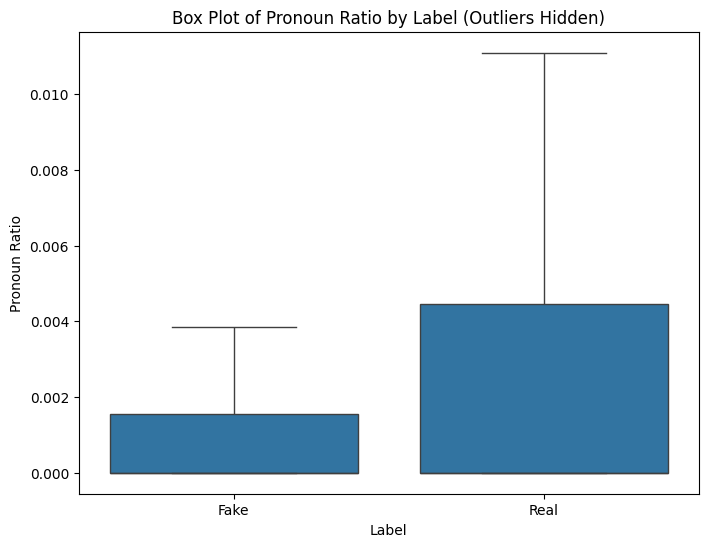

In [43]:
# Extract data for each label
pronoun_ratio_0 = data[data["label"] == 0]["pronoun_ratio"]
pronoun_ratio_1 = data[data["label"] == 1]["pronoun_ratio"]

# Combine the data into a single DataFrame for easier plotting
plot_data = pd.DataFrame({
    'pronoun_ratio': np.concatenate([pronoun_ratio_0.values, pronoun_ratio_1.values]),
    'label': ['Fake'] * len(pronoun_ratio_0) + ['Real'] * len(pronoun_ratio_1)
})

# Create the box plot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='pronoun_ratio', data=plot_data, showfliers=False)
plt.title('Box Plot of Pronoun Ratio by Label (Outliers Hidden)')
plt.xlabel('Label')
plt.ylabel('Pronoun Ratio')
plt.show()

#### 4) Modal Verb Ratio

**Importance**: Modal verbs (e.g., `can`, `could`, `may`, `might`, `should`, `will`) are used to express possibilities, permissions, obligations, or suggestions. Fake news articles may use modal verbs **more frequently** to speculate, create doubt, or suggest uncertainty without concrete evidence

**Purpose**:

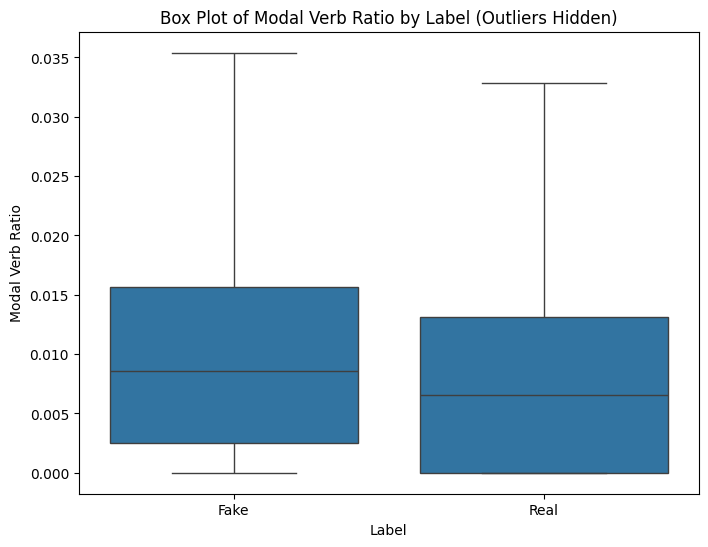

In [41]:
# Extract data for each label
modal_verb_ratio_0 = data[data["label"] == 0]["modal_verb_ratio"]
modal_verb_ratio_1 = data[data["label"] == 1]["modal_verb_ratio"]

# Combine the data into a single DataFrame for easier plotting
plot_data = pd.DataFrame({
    'modal_verb_ratio': np.concatenate([modal_verb_ratio_0.values, modal_verb_ratio_1.values]),
    'label': ['Fake'] * len(modal_verb_ratio_0) + ['Real'] * len(modal_verb_ratio_1)
})

# Create the box plot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='modal_verb_ratio', data=plot_data, showfliers=False)
plt.title('Box Plot of Modal Verb Ratio by Label (Outliers Hidden)')
plt.xlabel('Label')
plt.ylabel('Modal Verb Ratio')
plt.show()

#### 5) Adjective Ratio

**Importance**: Fake news tends to use more adjectives, especially extreme ones, to exaggerate or sensationalise the content. High usage of adjectives may indicate subjective or emotionally charged language, which is often used to attract attention or manipulate readers.

**Purpose**:

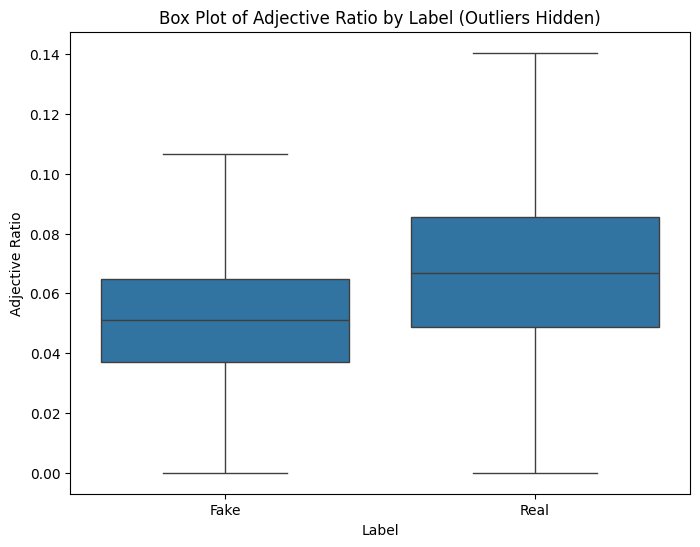

In [48]:
# Extract data for each label
negations_ratio_0 = data[data["label"] == 0]["negations_ratio"]
negations_ratio_1 = data[data["label"] == 1]["negations_ratio"]

# Combine the data into a single DataFrame for easier plotting
plot_data = pd.DataFrame({
    'negations_ratio': np.concatenate([negations_ratio_0.values, negations_ratio_1.values]),
    'label': ['Fake'] * len(negations_ratio_0) + ['Real'] * len(negations_ratio_1)
})

# Create the box plot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='negations_ratio', data=plot_data, showfliers=False)
plt.title('Box Plot of Adjective Ratio by Label (Outliers Hidden)')
plt.xlabel('Label')
plt.ylabel('Adjective Ratio')
plt.show()

#### 6) Word Cloud

**Purpose**: